In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, fbeta_score, f1_score, accuracy_score, average_precision_score
import seaborn as sns
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
train = pd.read_csv('./data/breast-cancer-diagnostic.shuf.lrn.csv')
test = pd.read_csv('./data/breast-cancer-diagnostic.shuf.tes.csv')
test_labels = pd.read_csv('./data/breast-cancer-diagnostic.shuf.sol.ex.csv')

In [ ]:
train.head()

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,9010598,False,12.76,18.84,81.87,496.6,0.09676,0.07952,0.02688,0.01781,...,13.75,25.99,87.82,579.7,0.1298,0.1839,0.1255,0.08312,0.2744,0.07238
1,892438,True,19.53,18.90,129.50,1217.0,0.11500,0.16420,0.21970,0.10620,...,25.93,26.24,171.10,2053.0,0.1495,0.4116,0.6121,0.19800,0.2968,0.09929
2,919555,True,20.55,20.86,137.80,1308.0,0.10460,0.17390,0.20850,0.13220,...,24.30,25.48,160.20,1809.0,0.1268,0.3135,0.4433,0.21480,0.3077,0.07569
3,8711003,False,12.25,17.94,78.27,460.3,0.08654,0.06679,0.03885,0.02331,...,13.59,25.22,86.60,564.2,0.1217,0.1788,0.1943,0.08211,0.3113,0.08132
4,895100,True,20.34,21.51,135.90,1264.0,0.11700,0.18750,0.25650,0.15040,...,25.30,31.86,171.10,1938.0,0.1592,0.4492,0.5344,0.26850,0.5558,0.10240


In [ ]:
train.isna().sum()

ID                         0
class                      0
radiusMean                 0
 textureMean               0
 perimeterMean             0
 areaMean                  0
 smoothnessMean            0
 compactnessMean           0
 concavityMean             0
 concavePointsMean         0
 symmetryMean              0
 fractalDimensionMean      0
 radiusStdErr              0
 textureStdErr             0
 perimeterStdErr           0
 areaStdErr                0
 smoothnessStdErr          0
 compactnessStdErr         0
 concavityStdErr           0
 concavePointsStdErr       0
 symmetryStdErr            0
 fractalDimensionStdErr    0
 radiusWorst               0
 textureWorst              0
 perimeterWorst            0
 areaWorst                 0
 smoothnessWorst           0
 compactnessWorst          0
 concavityWorst            0
 concavePointsWorst        0
 symmetryWorst             0
 fractalDimensionWorst     0
dtype: int64

In [ ]:
corr_matrix_abs = train.corr().abs()
corr_matrix = train.corr()
# the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))
       .stack()
       .sort_values(ascending=False))
print(sol[:20])

radiusMean         perimeterMean        0.998154
 radiusWorst       perimeterWorst       0.994150
 perimeterMean     areaMean             0.985856
radiusMean         areaMean             0.985666
 radiusWorst       areaWorst            0.983307
 perimeterWorst    areaWorst            0.979365
 radiusStdErr      perimeterStdErr      0.977151
 perimeterMean     radiusWorst          0.974368
                   perimeterWorst       0.973249
radiusMean         radiusWorst          0.972468
                   perimeterWorst       0.966734
 areaMean          areaWorst            0.964974
                   radiusWorst          0.960517
                   perimeterWorst       0.957065
 perimeterMean     areaWorst            0.952771
 radiusStdErr      areaStdErr           0.951750
radiusMean         areaWorst            0.949039
 perimeterStdErr   areaStdErr           0.943148
 concavityMean     concavePointsMean    0.927971
 textureMean       textureWorst         0.926446
dtype: float64


<AxesSubplot:>

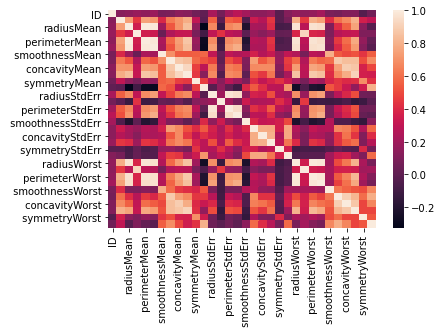

In [ ]:
sns.heatmap(train.corr())

<AxesSubplot:>

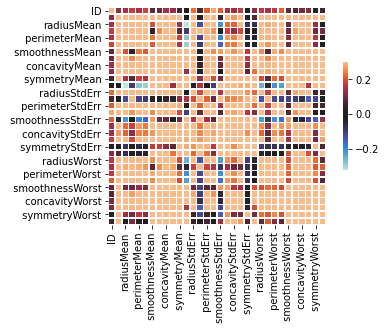

In [ ]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(train.corr(), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

def underSampling(X, Y):
    nm1 = NearMiss(version=1)
    X_resampled, y_resampled = nm1.fit_resample(X, Y)
    return X_resampled, y_resampled

def overSampling(X, Y):
    #smote = SMOTE(random_state=42)
    s = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = s.fit_resample(X, Y)
    return X_resampled, y_resampled

def combinedSampling(X, Y):
    smote_tomek = SMOTETomek(random_state=0)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, Y)
    return X_resampled, y_resampled

def getFeatureLabelData(dataset,classColumn, noIDColumn = False ):
    # dataset = read_data(train_url)
    if noIDColumn:
        X = dataset.drop(dataset.columns[[0, classColumn]], axis=1)
    else:
        X = dataset.drop(dataset.columns[[classColumn]], axis=1)

    Y = dataset.iloc[:, classColumn].values
    return X,Y

# def selectRandomForests(x_train_ds, y_train_ds, x_test_ds, y_test_ds, max_features):
#     x_train = SelectFromModel(RandomForestClassifier(n_estimators = 100), max_features=max_features)
#     x_train = x_train.fit_transform(x_train_ds, y_train_ds)
#     x_test = SelectFromModel(RandomForestClassifier(n_estimators = 100), max_features=max_features)
#     x_test = x_train.fit_transform(x_test_ds, y_test_ds)
#     return x_train, x_test


def selectRandomForests(x_train_ds, y_train_ds, x_test_ds, y_test_ds, max_features):
    clf = RandomForestClassifier(n_estimators = 100)

    sfm = SelectFromModel(clf)
    sfm.fit(x_train_ds, y_train_ds)
    X_important_train = sfm.transform(x_train_ds)
    X_important_test = sfm.transform(x_test_ds)
    return X_important_train, X_important_test


In [ ]:

X,y = getFeatureLabelData(train, 1)

X_train, y_train = underSampling(X, y)

# X_train = train.drop("class", axis=1)
# y_train = train["class"]
X_test = test
y_test = test_labels["class"]

In [ ]:
# scailing values
from data_handler import featureOneHotEncoding, minMaxScailing
X_train, X_test = minMaxScailing(X_train, X_test)

In [ ]:
X_train, X_test = selectRandomForests(X_train, y_train, X_test, y_test, 20 )

In [ ]:
predicted = grid_search.best_estimator_.predict(X_test)
fbeta_score(y_test, predicted, average='weighted', beta=0.5)

0.7569444444444444

## Randomforests classifier

In [ ]:
result = {}
accuracy = {}
params = {
    'criterion': ['gini', 'entropy'],
     'max_features': ['auto','sqrt','log2'],
      'n_estimators': [1, 10, 50, 100]
      }

resultRF = {}
best_RF = RandomForestClassifier()
max_f1_score_RF = 0

for k in range(5,11):
    print(k)
    grid_search_RF = GridSearchCV(RandomForestClassifier(),
                          params, cv=k, return_train_score=True)
    grid_search_RF.fit(X_train, y_train)
    y_pred = grid_search_RF.predict(X_test)
    score = f1_score(y_test, y_pred)
    acc_score = accuracy_score(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    
    if score > max_f1_score_RF:
        max_f1_score_RF = score
        best_RF = grid_search_RF.best_estimator_

    grid_search_RF.best_params_["f1_score"] = score
    grid_search_RF.best_params_["accuracy_score"] = acc_score
    # grid_search_RF.best_params_["average_precision_score"] = average_precision
    resultRF[k] = grid_search_RF.best_params_

5
6
7
8
9
10


In [ ]:
result

{}

In [ ]:
pd.DataFrame.from_dict(resultRF, orient='index').sort_values(by=['f1_score'], ascending=False)


,criterion,max_features,n_estimators,f1_score,accuracy_score
6,gini,sqrt,10,0.580000,0.408451
10,entropy,sqrt,50,0.580000,0.408451
5,gini,log2,50,0.576441,0.404930
8,entropy,auto,50,0.576441,0.404930
9,entropy,sqrt,100,0.576441,0.404930
7,gini,log2,1,0.569270,0.397887


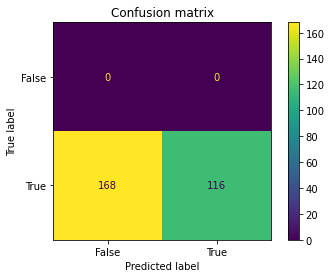

In [ ]:
# grid_search_RF
plot_confusion_matrix(grid_search_RF.best_estimator_, X_test, y_test)  
plt.title('Confusion matrix')
plt.savefig('figs/breast-cancer/RF-confusion-matrix.png', transparent=False)
plt.show()

In [ ]:
predicted = grid_search_RF.best_estimator_.predict(X_test)
fbeta_score(y_test, predicted, average='weighted', beta=0.5)

0.7623626373626373

## Support vector machines

In [ ]:
svc_params = {
     'C': [1,2,3,4,5,6,7,8,9,10],
    'kernel': ['linear','poly', 'rbf', 'sigmoid'],
    'degree': [1,2,3,4,5],
    'gamma': ['scale','auto']
}

resultSVC = {}
best_SVC = SVC()
max_f1_score_svc = 0
for k in range(5,11):
    print(k)
    grid_search_SVC = GridSearchCV(SVC(),
                          svc_params, cv=k, return_train_score=True)
    grid_search_SVC.fit(X_train, y_train)
    y_pred = grid_search_SVC.predict(X_test)
    score = f1_score(y_test, y_pred)
    score = f1_score(y_test, y_pred)
    acc_score = accuracy_score(y_test, y_pred)
    
    if score > max_f1_score_svc:
        max_f1_score_svc = score
        best_SVC = grid_search_SVC.best_estimator_

    grid_search_SVC.best_params_["f1_score"] = score
    grid_search_SVC.best_params_["accuracy_score"] = acc_score
    resultSVC[k] = grid_search_SVC.best_params_

5
6
7
8


KeyboardInterrupt: 

In [ ]:
resultSVC

{5: {'C': 2,
  'degree': 1,
  'gamma': 'scale',
  'kernel': 'linear',
  'score': 0.5169712793733682},
 6: {'C': 4,
  'degree': 1,
  'gamma': 'scale',
  'kernel': 'linear',
  'score': 0.5246753246753246},
 7: {'C': 1,
  'degree': 1,
  'gamma': 'scale',
  'kernel': 'linear',
  'score': 0.5169712793733682},
 8: {'C': 2,
  'degree': 1,
  'gamma': 'scale',
  'kernel': 'linear',
  'score': 0.5169712793733682},
 9: {'C': 1,
  'degree': 1,
  'gamma': 'scale',
  'kernel': 'linear',
  'score': 0.5169712793733682},
 10: {'C': 4,
  'degree': 1,
  'gamma': 'scale',
  'kernel': 'linear',
  'score': 0.5246753246753246}}

In [ ]:
pd.DataFrame.from_dict(resultSVC, orient='index').sort_values(by=['f1_score'], ascending=False)

,C,degree,gamma,kernel,f1_score,accuracy_score
8,6,1,scale,rbf,0.587065,0.415493
6,1,2,scale,poly,0.583541,0.411972
9,3,1,scale,rbf,0.576441,0.404930
5,2,1,scale,rbf,0.572864,0.401408
7,5,1,scale,rbf,0.572864,0.401408
10,1,5,scale,poly,0.558376,0.387324


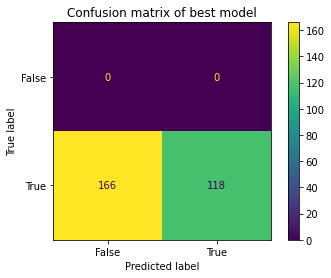

In [ ]:
matrix = plot_confusion_matrix(best_SVC, X_test, y_test)  
plt.title('Confusion matrix of best model')
plt.savefig('figs/breast-cancer/SVC-confusion-matrix.jpg', bbox_inches = 'tight')
plt.show(matrix)

KNN

In [ ]:
knn_params = {
    'n_neighbors': [1,3,5,7,9,10,12,14,15,17,20],
    'weights': ['uniform','distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'p': [1,2]
}
# from sklearn.neighbors import KNeighborsClassifier

resultKNN = {}
best_KNN = KNeighborsClassifier()
max_f1_score = 0

for k in range(5,11):
    print(k)
    grid_search_KNN = GridSearchCV(KNeighborsClassifier(),
                          knn_params, cv=k, return_train_score=True)
    grid_search_KNN.fit(X_train, y_train)
    y_pred = grid_search_KNN.predict(X_test)
    score = f1_score(y_test, y_pred)
    acc_score = accuracy_score(y_test, y_pred)
    
    if score > max_f1_score:
        max_f1_score = score
        best_KNN = grid_search_KNN.best_estimator_

    grid_search_KNN.best_params_["f1_score"] = score
    grid_search_KNN.best_params_["accuracy_score"] = acc_score
    resultKNN[k] = grid_search_KNN.best_params_


5
6
7
8
9
10


In [ ]:
resultKNN

{5: {'algorithm': 'auto',
  'n_neighbors': 10,
  'p': 1,
  'weights': 'uniform',
  'f1_score': 0.5013192612137204},
 6: {'algorithm': 'auto',
  'n_neighbors': 3,
  'p': 1,
  'weights': 'uniform',
  'f1_score': 0.5284974093264249},
 7: {'algorithm': 'auto',
  'n_neighbors': 1,
  'p': 1,
  'weights': 'uniform',
  'f1_score': 0.5435897435897437},
 8: {'algorithm': 'auto',
  'n_neighbors': 3,
  'p': 1,
  'weights': 'uniform',
  'f1_score': 0.5284974093264249},
 9: {'algorithm': 'auto',
  'n_neighbors': 10,
  'p': 1,
  'weights': 'uniform',
  'f1_score': 0.5013192612137204},
 10: {'algorithm': 'auto',
  'n_neighbors': 3,
  'p': 1,
  'weights': 'uniform',
  'f1_score': 0.5284974093264249}}

In [ ]:
pd.DataFrame.from_dict(resultKNN, orient='index').sort_values(by=['f1_score'], ascending=False)

,algorithm,n_neighbors,p,weights,f1_score,accuracy_score
6,auto,1,2,uniform,0.580000,0.408451
7,auto,1,2,uniform,0.580000,0.408451
5,auto,9,2,distance,0.565657,0.394366
8,auto,15,1,distance,0.554707,0.383803
9,auto,15,1,uniform,0.554707,0.383803
10,auto,14,1,distance,0.554707,0.383803


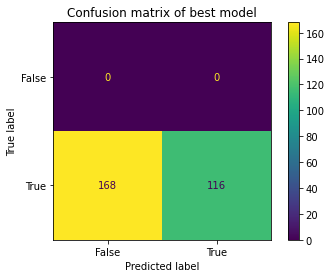

In [ ]:
plot_confusion_matrix(best_KNN, X_test, y_test)  
plt.title('Confusion matrix of best model')
plt.savefig('figs/breast-cancer/KNN-confusion-matrix.jpg', bbox_inches = 'tight')
plt.show(matrix)

## Comparison of our best models

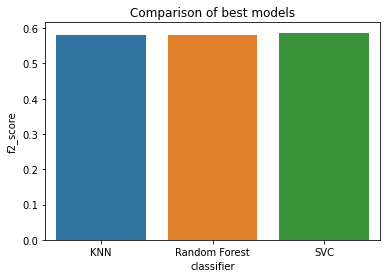

In [ ]:
d = {'classifier': ["KNN","Random Forest", "SVC"], 'f2_score': [0.580000, 0.580000, 0.587065]}
df = pd.DataFrame(data=d)

sns.barplot(x="classifier", y="f2_score", data=df)
plt.title('Comparison of best models')
plt.savefig('figs/breast-cancer/comparison.jpg', bbox_inches = 'tight')